# HarvestStat Data Profiling - Nigeria

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# CPCV2 grain code ------------------------------ #
grain_code = pd.read_hdf('../data/crop/grain_cpcv2_code.hdf')
product_category = grain_code[['product', 'product_category']].set_index('product').to_dict()['product_category']
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:26331' # Nigeria
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/NG_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Nigeria',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:all'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 1991	 | NG1991A1 | 31	| nan	| 0	| nan	| 0	|
| 1996	 | NG1996A1 | 37	| nan	| 0	| nan	| 0	|
| 2014	 | NG2014A1 | 37	| NG2014A2	| 774	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'

# ----------------------------------------------- #
#Drop the blank (nan) rows that are duplicates of rows that do have data
df = df[np.isfinite(df.value)]

#Drop duplicate values. This will be fixed in the new data upload. Check carefully after new upload
df = df[~(df[['fnid','crop_production_system','season_year', 'product','indicator','population_group']].duplicated())]
 
# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([NG_Admin1_1996], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #s

- Remove missing records ---------------------- #
Orignial data points: 27,787
9,149/9,149 "Area Planted" points are retained.
9,584/9,584 "Quantity Produced" points are retained.
9,054/9,054 "Yield" points are retained.
Current data points: 27,787

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1999 - 2023
21 grain types are found: Bananas/Plantains, mixed, Cassava, Cotton (Unspecified), Cowpea (unspecified), Ginger, Groundnut (without shell), Groundnuts (In Shell), Maize (Corn), Melon (unspecified), Millet, Okras (Fresh), Onions, Rice (Paddy), Sesame Seed, Sorghum, Soybean (unspecified), Sweet Potatoes, Taro/Cocoyam (Unspecified), Tomato, Wheat Grain, Yams
2 seasons are found: Annual (12-01), Wet (06-01)
1 crop production system are found: All (PS)
Data sources include:
[1] NAERLS, Nigeria --- Crop Area and Output Forecast, Nigeria
[2] NAERLS, Nigeria --- FEWS NET Agro Maps, Nigeria
[3] NAERLS, Nigeria --- National Pr

In [4]:
# Remove incomplete records -------------------------- #
# Generate virtual IDs to each set of ['fnid','crop_production_system','season_year', 'product'].
df['vid'] = 0
indicators = ['Area Harvested', 'Area Planted', 'Quantity Produced', 'Yield']
vid_dict = dict()
records = df[['fnid','crop_production_system','season_year','product']].drop_duplicates().reset_index(drop=True)
records[indicators] = np.nan

bad = []

for i, row in records.iterrows():
    fnid, crop_production_system, season_year, product_name = row[['fnid','crop_production_system','season_year','product']]
    sub = df[
        (df['fnid'] == fnid) &
        (df['crop_production_system'] == crop_production_system) &
        (df['season_year'] == season_year) &
        (df['product'] == product_name)
    ]
    # Ignore if either area, production, and yield is missing
    n_points = sub.shape[0]
    if n_points < 3: continue
    if n_points > 4: 
        bad.append(sub)

- Nigeria crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-nigeria.png" width=900><br>

<img src="../figures/crop_calendar/Nigeria_-_Crop_calendar.jpg" width=900>

- FDW data consists of `NG1996A1`.

| Year  | Admin-1  | # units  | Admin-2  | # units |
| :---: | :----:   | :----:   | :----:   | :---:   |
| 1991  | NG1991A1 | 31       | -        | -       |
| 1996  | NG1996A1 | 37       | -        | -       |
| 2014  | NG2014A1 | 37       | NG2014A2 | 774     |

- Comparison between admin boundaries.

<img src="../figures/NG_admin_shapes.png" width=900>

- **`NG1996A1`** is used to represent the current admin-level 1 crop data.
- Nigeria has a single crop season: `Wet`.
- Nigeria has no population group(s).

In [5]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = NG_Admin1_1996.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
shape_used['ADMIN2'] = 'None'
shape_all['ADMIN2'] = 'None'
shape_latest['ADMIN2'] = 'None'
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area_new, prod_new = FDW_PD_Compiling(df, shape_used)
# ----------------------------------------------- #

In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Bananas/Plantains, mixed':'Bananas/Plantains, mixed',
    'Cassava':'Cassava',
    'Cotton (Unspecified)':'Cotton',
    'Cowpea (unspecified)':'Cowpeas',
    'Ginger':'Ginger',
    'Groundnuts (In Shell)':'Groundnuts (In Shell)',
    'Groundnut (without shell)': 'Groundnuts (Without Shell)',
    'Maize (Corn)':'Maize',
    'Melon (unspecified)':'Melon',
    'Millet':'Millet',
    'Okras (Fresh)':'Okras',
    'Onions':'Onions',
    'Rice (Paddy)':'Rice (Paddy)',
    'Sesame Seed':'Sesame Seed',
    'Sorghum':'Sorghum',
    'Soybean (unspecified)':'Soybean',
    'Sweet Potatoes':'Sweet Potatoes',
    'Taro/Cocoyam (Unspecified)':'Cocoyam',
    'Tomato':'Tomato',
    'Wheat Grain':'Wheat',
    'Yams':'Yams'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Nigeria']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0


All [season_name, product, crop_production_system] are in the external crop calendar.


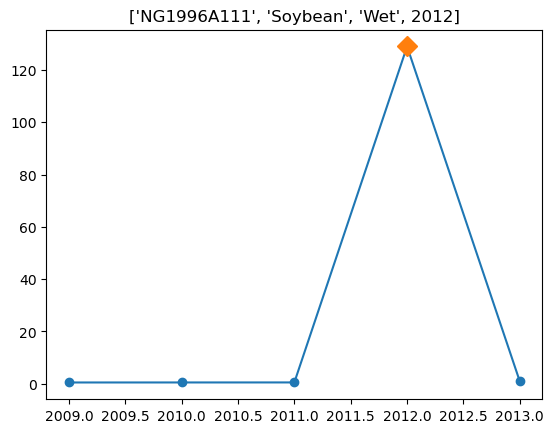

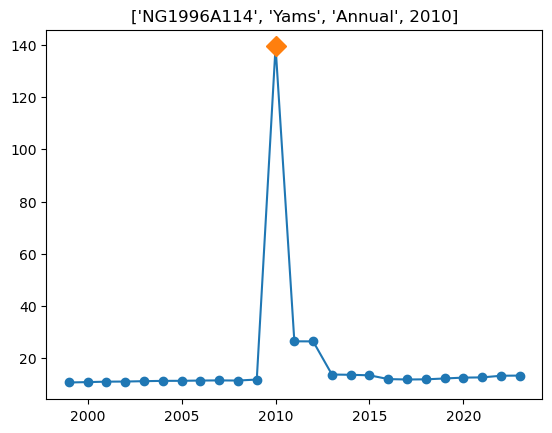

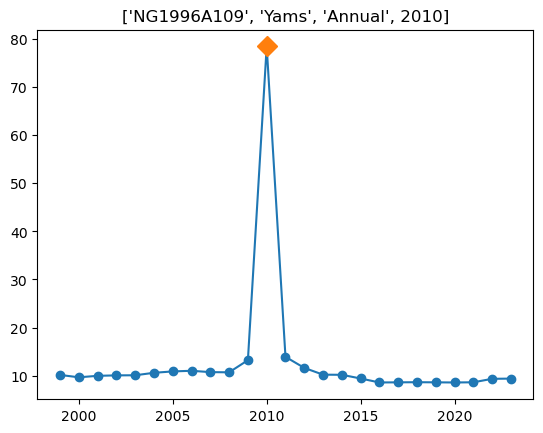

In [7]:
from matplotlib import pyplot as plt

outliers = [['NG1996A111','Soybean','Wet',2012],
            ['NG1996A114','Yams','Annual',2010],
            ['NG1996A109','Yams','Annual',2010],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title(str(iou))
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1   
   

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_NG.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_NG_ratio.npz', link_ratio)

../data/crop/adm_crop_production_NG.csv is saved.
../data/crop/adm_crop_production_NG_ratio.npz is saved.


# Visualization of production data

/Users/wanders7/Documents/Code/Project/NASA_GSCD/gscd/notebook/tools_graphic.py:433: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axes[1].grid(which='minor', axis='x', linestyle='-', color='black', visible=False)


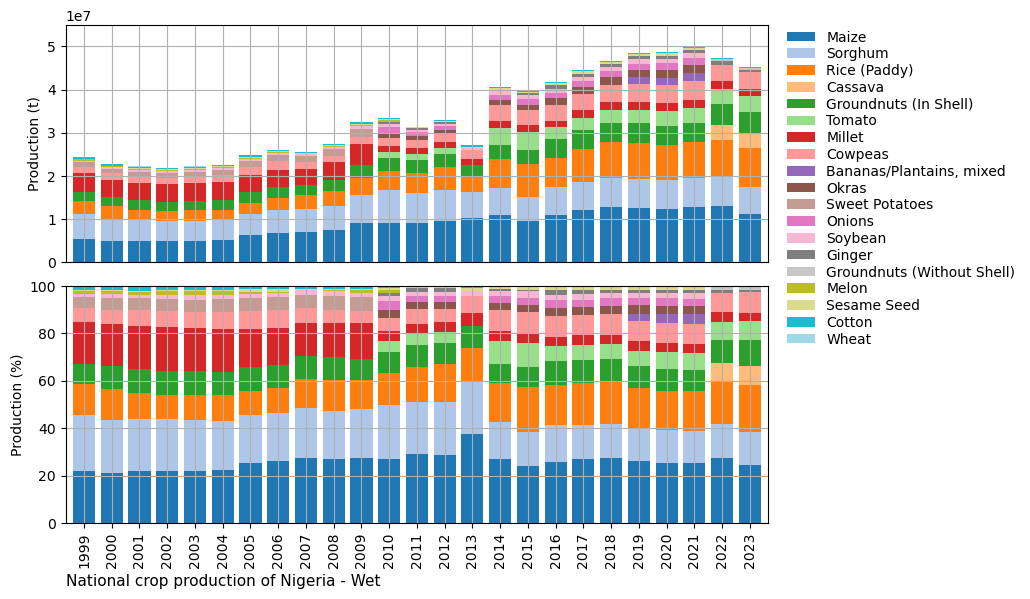

../figures/NG_bar_natgrainprod_Wet.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'NG', 'Nigeria'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Wet']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

TypeError: pointplot() got an unexpected keyword argument 'linewidth'

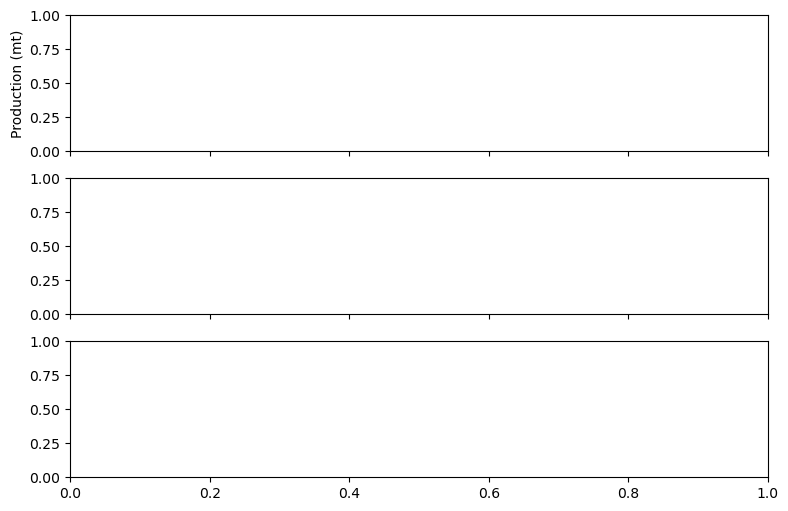

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'NG', 'Nigeria'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet','Wet'],
    ['Sorghum','Wet'],
    ['Maize','Wet'],
    ['Rice (Paddy)','Wet'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)